# Imports

In [2]:
import os
import pandas as pd
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
##IMPORTANT: use this on the native dataframe (likely in another notebook). 
def clean_holidays(df):
    df["date"] = pd.to_datetime(df["date"]).dt.date
    pass


# Data

## Declaration

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

In [5]:
transx = pd.read_csv("../data/transactions.csv")
stores = pd.read_csv("../data/stores.csv")
oil = pd.read_csv("../data/oil.csv")
holidays = pd.read_csv("../data/holidays_events.csv")

training = pd.read_csv("../data/train.csv")
testing = pd.read_csv("../data/test.csv")
sample = pd.read_csv("../data/sample_submission.csv")

## Attributes

### Transactions

In [6]:
transx.head()

display(transx.head())

print(f"Shape: {transx.shape} \n")
print(f"Size: {transx.size} \n")
print(f"Nulls: {transx.isnull().sum()} \n")
print(f"Dtypes: {transx.dtypes} \n")

print(f"Date check: {type(transx['date'][0])}")

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Shape: (83488, 3) 

Size: 250464 

Nulls: date            0
store_nbr       0
transactions    0
dtype: int64 

Dtypes: date            object
store_nbr        int64
transactions     int64
dtype: object 

Date check: <class 'str'>


Date will need to be converted into a datetime object. Values to be explored. 

### Stores

In [7]:
display(stores.head())

print(f"Shape: {stores.shape} \n")
print(f"Size: {stores.size} \n")
print(f"Nulls: {stores.isnull().sum()} \n")
print(f"Dtypes: {stores.dtypes} \n")

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Shape: (54, 5) 

Size: 270 

Nulls: store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64 

Dtypes: store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object 



Store number could be used here to match up to transactions. There are only 54 rows. Will be checking upon the join to transactions if any stores are omitted.  

### Oil

In [6]:
display(oil.head())

print(f"Shape: {oil.shape} \n")
print(f"Size: {oil.size} \n")
print(f"Nulls: {oil.isnull().sum()} \n")
print(f"Dtypes: {oil.dtypes} \n")

print(type(oil["date"][0]))

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Shape: (1218, 2) 

Size: 2436 

Nulls: date           0
dcoilwtico    43
dtype: int64 

Dtypes: date           object
dcoilwtico    float64
dtype: object 

<class 'str'>


Date will need to be converted to datetime objects. Need to make sense of the oil price column. There are also nulls. Must address what to do if dates don't line up. It's likely best to observe how much oil prices fluctuate and then extrapolate if possible. 

### Holidays

In [7]:
holidays.head()

display(holidays.head())

print(f"Shape: {holidays.shape} \n")
print(f"Size: {holidays.size} \n")
print(f"Nulls: {holidays.isnull().sum()} \n")
print(f"Dtypes: {holidays.dtypes} \n")

print(f"Date check: {type(holidays['date'][0])}")

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Shape: (350, 6) 

Size: 2100 

Nulls: date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64 

Dtypes: date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object 

Date check: <class 'str'>


Date needs to be converted to datetime object. Holidays will be useful for understanding any captured anomalies our model may pickup. We will keep them in mind when interpreting inaccuracy in scores or any explanation of our model's limits. These anamolies are ordinal, as well. We can likely fine tune a model to understand these events and treat them in a specific way that best helps us plan for our business' supply and demand. 

### Training

In [8]:
training.head()

display(training.head())

print(f"Shape: {training.shape} \n")
print(f"Size: {training.size} \n")
print(f"Nulls: {training.isnull().sum()} \n")
print(f"Dtypes: {training.dtypes} \n")

print(f"Date check: {type(training['date'][0])}")

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Shape: (3000888, 6) 

Size: 18005328 

Nulls: id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64 

Dtypes: id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object 

Date check: <class 'str'>


Date conversion needed here. Surprisingly no nulls. Will be joining up against `date`, after all the coincident columns have matching datetime keys.  

### Testing

In [9]:
testing.head()

display(testing.head())
print(f"Shape: {testing.shape} \n")
print(f"Size: {testing.size} \n")
print(f"Nulls: {testing.isnull().sum()} \n")
print(f"Dtypes: {testing.dtypes} \n")

print(f"Date check: {type(testing['date'][0])}")

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


Shape: (28512, 5) 

Size: 142560 

Nulls: id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64 

Dtypes: id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object 

Date check: <class 'str'>


So testing data omits some of the other data. The question now begs is how do we correctly apply all the data we have to work with to plug into the testing data? 

## Cleaning

### Datetime Conversion

In [8]:
## Datetime conversion function

dated_dfs = [transx, oil, holidays, training]
# testing["date"] = pd.to_datetime(testing["date"]) #this is to show how we'll tag our testing df with all the pre-processing we need {A function will be the result of housing all the cleaning}


for df in dated_dfs:
    df["date"] = pd.to_datetime(df["date"]).dt.date
    print(type(df["date"][0]))

<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>


With the proper conversion of our dataframes' `"date"` column, we have been able to promote their data types into more charismatic data. Pandas is now able to recognize the column with ordinality instead of solely recognizing it as a nominal data type - which it was doing previously. From the perspective of the human eye, we readers understand the column implicitly as something with ordinality. Computers have simple thinking, where the concept of ordinality is not implicitly understood upon first glance - only able to access each object's attribute just a string.

Furthermore, some comments were included in the above cell to reference how we will conduct a similar process on our testing data. The functions housing such will be provided at the top of the notebook.

### Value Exploration

#### Datetime Exploration

**All Dfs**

In [9]:
##Minimums and Maximums on Training Data alone (we won't be able to understand any testing data)

dated_df_names = ["Transactions:", "Oil:", "Holidays:", "Training:"]

for index, df in enumerate(dated_dfs):
    print(f"Showing table for {dated_df_names[index]}")
    print(f"Min: {df['date'].min()}")
    print(f"Max: {df['date'].max()} \n")

Showing table for Transactions:
Min: 2013-01-01
Max: 2017-08-15 

Showing table for Oil:
Min: 2013-01-01
Max: 2017-08-31 

Showing table for Holidays:
Min: 2012-03-02
Max: 2017-12-26 

Showing table for Training:
Min: 2013-01-01
Max: 2017-08-15 



We notice several years worth of data here (which sounds great!). `holidays` records the largest spread of dates with an absolute minimum and maximum respectively `2012-03-02` and `2017-12-26`. The other tables (`transx`, `oil`, and `training`) all showcase a start date of `2013-01-01`. `oil` extends beyond `transx`'s and `trainings`'s maximums of `2017-08-15` which an end date of `2017-08-31`. The mismatch in size will be noted and addressed as we press forward. 

Additional note: We only focus on the `training` ( + complementary datasets we are able to leverage) data as it would be mostly impractical to perform the same analysis on our `testing` data. We won't be able to understand our unknown data's date range until we already begin sicking our model on the data. This will also prevent any leakage of data and force us to work around real-world constraints. However, the work we can accomplish on the training data might be generalized enough to consider sensible kpis built off of our `date` column, which could be implemented. 

In [10]:
#date_differences checking

for index, dated_df in enumerate(dated_dfs):
    max_date = dated_df['date'].max() 
    min_date = dated_df['date'].min()
    absolute_date_difference = (max_date - min_date).days
    table_row_count = dated_df.shape[0]

    print(f"Date difference of {dated_df_names[index]}:")
    print(f"{absolute_date_difference} days <- ({max_date} - {min_date})")
    print(f"The rows of the native table is: {table_row_count} \n \n")

#TODO: re-approach the issue and its relevance to wards modeling. 

#date_counts checking

 

Date difference of Transactions::
1687 days <- (2017-08-15 - 2013-01-01)
The rows of the native table is: 83488 
 

Date difference of Oil::
1703 days <- (2017-08-31 - 2013-01-01)
The rows of the native table is: 1218 
 

Date difference of Holidays::
2125 days <- (2017-12-26 - 2012-03-02)
The rows of the native table is: 350 
 

Date difference of Training::
1687 days <- (2017-08-15 - 2013-01-01)
The rows of the native table is: 3000888 
 



We expected this data to have differences in days. So this is unsurprising. However, the days difference between the training and transactions table is effectively the same. What could this mean? 

In [11]:
#days between per df

for index, dated_df in enumerate(dated_dfs):
    print("----------")
    print(f"Editing: {dated_df_names[index]}")
    dated_df["days_diff"] = dated_df["date"].diff().dt.days
    display(dated_df["days_diff"].value_counts().sort_values(ascending=False))
    

#TODO: re-approach the issue and its relevance to wards modeling.
# test_df = transx.copy()

# test_df["days_diff"] = transx["date"].diff().dt.days

----------
Editing: Transactions:


days_diff
0.0    81806
1.0     1675
2.0        6
Name: count, dtype: int64

----------
Editing: Oil:


days_diff
1.0    974
3.0    243
Name: count, dtype: int64

----------
Editing: Holidays:


days_diff
1.0     133
0.0      38
2.0      33
3.0      23
5.0      17
9.0      13
11.0     11
8.0      10
13.0      8
30.0      7
7.0       7
10.0      6
35.0      6
23.0      5
20.0      5
4.0       4
12.0      4
24.0      3
22.0      2
28.0      2
21.0      2
60.0      1
42.0      1
19.0      1
16.0      1
37.0      1
18.0      1
15.0      1
38.0      1
27.0      1
56.0      1
Name: count, dtype: int64

----------
Editing: Training:


days_diff
0.0    2999204
1.0       1679
2.0          4
Name: count, dtype: int64

It makes no sense for us to currently incorporate a `days_diff` column before our merge. Some of our merging will utilize the `date` column as a coincident key. Therefore, there will be inconsistency in bringing our respecting date difference columns - especially if the choice is to potentially omit some dates or duplicate some dates for cleaner processing. 

`transx` and `training` again show strong consistencies with one another through absolute date differences and through spread of `days_diff`. 

#### `Holidays` 

**Dates**

We will want to pay attention to the holidays present in this case. A reason being is because of the areas where `days_diff` is high. Some questions to consider:
- can we leverage any information from this table to extrapolate holiday existence?
- are there any locations inconsistent with a Favorita store? (likely to be studied in a different section and then be otherwise found in the appendix).
- how many holidays are there per year? per month? per day?
- most frequent kind of holiday

In [12]:
#TODO: in this section, need to address some aggregations and focus on uniqueness breakdown of things.

**Observing `days_diff` composition**

In [13]:
##Looks at the days difference between holidays
display(holidays.dropna().sort_values(by="days_diff", ascending=False).head(50))

,date,type,locale,locale_name,description,transferred,days_diff
93,2014-03-02,Holiday,Local,Manta,Fundacion de Manta,False,60.0
299,2017-02-27,Holiday,National,Ecuador,Carnaval,False,56.0
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False,42.0
212,2016-02-08,Holiday,National,Ecuador,Carnaval,False,38.0
162,2015-02-16,Holiday,National,Ecuador,Carnaval,False,37.0
188,2015-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,False,35.0
70,2013-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,False,35.0
133,2014-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,False,35.0
17,2012-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,False,35.0
272,2016-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,False,35.0


The above truly isn't enough of a look to understand more about these days difference gaps. We need to dig more into the rest of the dataframe to better know how it is all composed. 

**Observing General Composition and Attributes**

In [14]:
##count the number of local of holidays and the number of cities it's in. 

display(
    holidays
    .groupby(["locale"])
    .agg(
        description_count = ("description", "count"), 
        locale_name_count = ("locale_name", "count"), 
        transferred_count = ("transferred", "count"),
        type_count = ("type", "count"),
        description_unique_count = ("description", "nunique"), 
        locale_name_unique_count = ("locale_name", "nunique"),
        transferred_unique_count = ("transferred", "nunique"),
        type_unique_count = ("type", "nunique")
    )
)


local_filter = holidays["locale"] == "Local"
regional_filter = holidays["locale"] == "Regional"
national_filter = holidays["locale"] == "National"


#We want to find the intercepts I guess
#See if descriptions are overlapping (if so, are we finding the same information posed on a per day basis?)
local_locale_names = list(holidays[local_filter]["locale_name"].unique())
local_description_names = list(holidays[local_filter]["description"].unique())

regional_locale_names = list(holidays[regional_filter]["locale_name"].unique())
regional_description_names = list(holidays[regional_filter]["description"].unique())

national_locale_names = list(holidays[national_filter]["locale_name"].unique())
national_description_names = list(holidays[national_filter]["description"].unique())


local_coincident_regional_locale_names = [x for x in local_locale_names if x in regional_locale_names]
local_coincident_national_locale_names = [x for x in local_locale_names if x in national_locale_names]
regional_coincident_national_locale_names = [x for x in regional_locale_names if x in national_locale_names]
print("Coincident Locale Names")
coincident_locale_names = [local_coincident_regional_locale_names, local_coincident_national_locale_names, regional_coincident_national_locale_names]
print(coincident_locale_names)


local_coincident_regional_description_names = [x for x in local_description_names if x in regional_description_names]
local_coincident_national_description_names = [x for x in local_description_names if x in national_description_names]
regional_coincident_national_description_names = [x for x in regional_description_names if x in national_description_names]
print("Coincident Descriptions")
coinciden_description_names = [local_coincident_regional_description_names, local_coincident_national_description_names, regional_coincident_national_description_names]
print(coinciden_description_names)




,description_count,locale_name_count,transferred_count,type_count,description_unique_count,locale_name_unique_count,transferred_unique_count,type_unique_count
locale,,,,,,,,
Local,152,152,152,152,27,19,2,3
National,174,174,174,174,72,1,2,6
Regional,24,24,24,24,4,4,1,1


Coincident Locale Names
[[], [], []]
Coincident Descriptions
[[], [], []]


Left 4 columns are there to showcase some split reference on hand-curated features hypothesized to have consistsnecy. They will obviously correspond. We use the right side of the above table to look at the amount of unique values found here. 

Above we checked for any coincidence among our table's naming patterns and descriptions for holidays. The table shows sophistication as we aren't finding there to be multi-hierarchical redundant information. Checking the coincidence programmatically proves this above, as far as we know. "Regional" holidays has a low amount of presence here. Most holidays are national holidays It may be worth examining it further 

We will explore the less understood columns and try and infer upon some specific patterns we can pull from `type`. I may begin to search for external sources on this dataset. 

**Observing the `transferred` column and reasoning its existence and meaning**

In `holidays`, the `locale` column contains two unique nominal values where it specifies the holiday to be on a regional or national scale. However, when counting values and unique values of some others against the grouped by `locale` column, we notice there will always be an "Ecuador" value in the `locale_name` corresponding to every value of "National" in the `locale` column. Therefore, we can reduce the width of the table by dropping the `locale` column as it contains redundant information that can be implied by the `locale_name`. 

The `transferred_count` on the aggregated 

There also appears to be a one-for-one correspondence of the `transferred` column which is boolean. There is a case to be made here where we may find redundant information. I believe there is more value in grouping the names of each holiday (`description`) as my hypothesis is that `transferred` denotes the amount of time the holiday appears. Not sure. There may also be some value in grouping by `description` and `transferred` to check 

In [15]:

##Counts the amount of transferred grouped off description
print("`Transferred` count grouped by holiday `description` \n ")
display(
    holidays
    .groupby(["description", "transferred"])
    .agg(
        transferred_count = ("transferred", "count"), 
    )
    .sort_values(by="transferred_count", ascending=False)
    .head()
)



#Further breaks down the transferred cout of holidays to observe against locale_name
print("`Transferred` count grouped by holiday `description` AND `locale_name` \n ")
display(
    holidays
    .groupby(["description", "locale_name", "transferred"])
    .agg(
        transferred_count = ("transferred", "count"), 
    )
    .sort_values(by="transferred_count", ascending=False)
    .head(20)
)





print("`Transferred` count grouped by holiday `description` AND `locale_name` but sorted by `description`, `locale_name` and `transferred` \n ")
display(
    holidays
    .groupby(["description", "locale_name", "transferred"])
    .agg(
        transferred_count = ("transferred", "count"), 
    )
    .sort_values(by=["description", "locale_name", "transferred"], ascending=False)
    .head(20)
)



print("`Transferred` count grouped by holiday `description`, `locale_name` AND `type` but sorted by `description`, `locale_name` and `transferred` \n ")
display(
    holidays
    .groupby(["description", "locale_name", "transferred", "type"])
    .agg(
        transferred_count = ("transferred", "count"), 
    )
    .sort_values(by=["description", "locale_name", "transferred"], ascending=False)
    .head(20)
)

`Transferred` count grouped by holiday `description` 
 


,,transferred_count
description,transferred,
Carnaval,False,10
Navidad-4,False,6
Fundacion de Cuenca,False,6
Fundacion de Esmeraldas,False,6
Navidad-2,False,6


`Transferred` count grouped by holiday `description` AND `locale_name` 
 


,,,transferred_count
description,locale_name,transferred,
Carnaval,Ecuador,False,10
Navidad-4,Ecuador,False,6
Fundacion de Cuenca,Cuenca,False,6
Fundacion de Esmeraldas,Esmeraldas,False,6
Navidad-2,Ecuador,False,6
Navidad-1,Ecuador,False,6
Navidad+1,Ecuador,False,6
Fundacion de Ibarra,Ibarra,False,6
Navidad,Ecuador,False,6


`Transferred` count grouped by holiday `description` AND `locale_name` but sorted by `description`, `locale_name` and `transferred` 
 


,,,transferred_count
description,locale_name,transferred,
Viernes Santo,Ecuador,False,5
Traslado Primer dia del ano,Ecuador,False,1
Traslado Primer Grito de Independencia,Ecuador,False,2
Traslado Independencia de Guayaquil,Ecuador,False,3
Traslado Fundacion de Quito,Quito,False,1
Traslado Fundacion de Guayaquil,Guayaquil,False,1
Traslado Batalla de Pichincha,Ecuador,False,2
Terremoto Manabi+9,Ecuador,False,1
Terremoto Manabi+8,Ecuador,False,1


`Transferred` count grouped by holiday `description`, `locale_name` AND `type` but sorted by `description`, `locale_name` and `transferred` 
 


,,,,transferred_count
description,locale_name,transferred,type,
Viernes Santo,Ecuador,False,Holiday,5
Traslado Primer dia del ano,Ecuador,False,Transfer,1
Traslado Primer Grito de Independencia,Ecuador,False,Transfer,2
Traslado Independencia de Guayaquil,Ecuador,False,Transfer,3
Traslado Fundacion de Quito,Quito,False,Transfer,1
Traslado Fundacion de Guayaquil,Guayaquil,False,Transfer,1
Traslado Batalla de Pichincha,Ecuador,False,Transfer,2
Terremoto Manabi+9,Ecuador,False,Event,1
Terremoto Manabi+8,Ecuador,False,Event,1


So the question still begs, when trying to observe on our own "blindly", what does `transferred` even mean? The counts of such are a little sporadic. When sorting and observing the by the `head()` of the dataframes, there are many `False` booleans present. 

We've completely omitted our observation thus far on the composition of data types present per column. Let's focus on `holidays` in particular...

In [16]:
display(
    holidays["transferred"].value_counts()
)

display(
    holidays[
        holidays["transferred"] == True
    ]
)

display(
    holidays[
        holidays["transferred"] == False
    ]
)

transferred
False    338
True      12
Name: count, dtype: int64

,date,type,locale,locale_name,description,transferred,days_diff
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2.0
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2.0
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2.0
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True,8.0
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True,1.0
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True,5.0
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True,1.0
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True,11.0
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True,10.0
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True,5.0


,date,type,locale,locale_name,description,transferred,days_diff
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,30.0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,11.0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2.0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,7.0
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,0.0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1.0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1.0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1.0


One thing visually noticed when the `transferred` column is set to `True` is that the holiday "Indepencia de Guyaquil". While this is a quick small sample pattern noticed here (with no current way to prove its correspondance through the commands we provided above; we would just need to look at coincidence of the descriptions).

Yet, I don't believe it will be a smart use of time to do such. Actually, through a small search on Google of the dataset, I was able to find a link that discusses some of the attributes of the tables in our project. [The link can be found here that goes over a project regarding Kaggle's Favorita dataset](https://medium.com/@baakwadegraftmiah/time-series-forecasting-predictive-model-building-for-store-sales-at-favorita-grocery-retailer-b5ef9d262b7b). `transferred` is to be treated as a "normal" day.....this likely means the holiday still truly exists, but there is not enough of a celebration that warrants a day off. In this case, we'll leave this column alone. We can rely on this for now to be our reasoning going forward.

**Observing the actual holiday descriptions**

In [17]:
##Looks at individual holidays
display(holidays["description"].value_counts(ascending=True).head(20))
display(holidays["description"].value_counts(ascending=True).tail(5))

description
Traslado Fundacion de Quito                        1
Terremoto Manabi+11                                1
Mundial de futbol Brasil: Ecuador-Honduras         1
Terremoto Manabi+9                                 1
Terremoto Manabi+8                                 1
Terremoto Manabi+7                                 1
Terremoto Manabi+6                                 1
Terremoto Manabi+5                                 1
Terremoto Manabi+4                                 1
Terremoto Manabi+3                                 1
Terremoto Manabi+2                                 1
Terremoto Manabi+1                                 1
Terremoto Manabi                                   1
Recupero Puente Primer dia del ano                 1
Recupero Puente Navidad                            1
Recupero puente Navidad                            1
Recupero puente primer dia del ano                 1
Mundial de futbol Brasil: Final                    1
Mundial de futbol Brasil: Tercer y

description
Fundacion de Loja       6
Fundacion de Manta      6
Fundacion de Ibarra     7
Fundacion de Cuenca     7
Carnaval               10
Name: count, dtype: int64

Furthermore, there is an alarming description of holidays with a "+n" suffix to some holidays (observed with `"Terremoto Manabi"` subset of holidays). It seems straightforward to remove such suffix in my oopinion as the inclusion of such to sustain the celebration of a specific holiday can be inferred upon AND removing this suffix will also eventually reduce the width of our modeling dataframe. The information loss is not significant as the `date` colummn will still be a way to understand how a holiday's celebration will persist beyond a single day (assuming we don't have significant gaps corresponding to a single holiday). On this last mentioned note in the previous sentence, it is also likely that checkiing for such will continue to make our work inefficient as we pay attention to nuances specific attributes. The cost of time and effort vs the confirmation of a small error or not may not outweigh the benefits of our modeling. 

Furthermore, it's important to mention that the model is not implicitly understanding of what the concept of a holiday is to humans. Through data alone, it will only find a pattern of `date` matching to `description`. When a true holiday extends multiple days, the model would not need to recognize the "+n" values - again the information is indirectly sustained through iteration of days. 

We will use `regex` expressions built into `pandas` to fix this dynamically where our fix will only apply to the candidate strings.

In [18]:
test_holiday = holidays.copy()

test_holiday["description"] = test_holiday["description"].str.replace(r'\+\d+$', '', regex=True) #removes +n from specific holidays
test_holiday["description"] = test_holiday["description"].str.replace(r'\-\d+$', '', regex=True) #removes -n from specific holidays

sorted(test_holiday["description"].unique())

['Batalla de Pichincha',
 'Black Friday',
 'Cantonizacion de Cayambe',
 'Cantonizacion de El Carmen',
 'Cantonizacion de Guaranda',
 'Cantonizacion de Latacunga',
 'Cantonizacion de Libertad',
 'Cantonizacion de Quevedo',
 'Cantonizacion de Riobamba',
 'Cantonizacion de Salinas',
 'Cantonizacion del Puyo',
 'Carnaval',
 'Cyber Monday',
 'Dia de Difuntos',
 'Dia de la Madre',
 'Dia del Trabajo',
 'Fundacion de Ambato',
 'Fundacion de Cuenca',
 'Fundacion de Esmeraldas',
 'Fundacion de Guayaquil',
 'Fundacion de Ibarra',
 'Fundacion de Loja',
 'Fundacion de Machala',
 'Fundacion de Manta',
 'Fundacion de Quito',
 'Fundacion de Riobamba',
 'Fundacion de Santo Domingo',
 'Inauguracion Mundial de futbol Brasil',
 'Independencia de Ambato',
 'Independencia de Cuenca',
 'Independencia de Guaranda',
 'Independencia de Guayaquil',
 'Independencia de Latacunga',
 'Mundial de futbol Brasil: Cuartos de Final',
 'Mundial de futbol Brasil: Ecuador-Francia',
 'Mundial de futbol Brasil: Ecuador-Hondur

An additional `regex` expression was used as it was discovered there are `-n` suffixes recognized, likely noting pre-holiday significant events coinciding to the corresponding holidays (think Christmas Eve paired with Christmas OR New Year's Eve paired with New Year's Day). 

Finally, there does not seem to be any other aspects to pay attention to on this. Thereofre, we will begin creating a cleaning script that focuses only on the `holidays` dataframe. Such script will do:
- convert `date` from string type to a datetim object
- omit the creation of a `days_diff` column or simply remove it if it was already created from a previous process
- use `regex` to address the suffixes.

In [19]:
#TODO: make a script that does the above to the native `holidays` dataframe. 

##### Plotting

In [20]:
#plot idea: show the distribution of events, holidays, and others
#plot idea: aggregate the number of holidays per day and see how many happen per day sometimes (color coding the holiday type break down could help, but also who cares)
#plot idea: holidays per city/region?

#### Transactions and Training

In [21]:
display(transx.head(20))

display(training.head(20))

,date,store_nbr,transactions,days_diff
0,2013-01-01,25,770,NaN
1,2013-01-02,1,2111,1.0
2,2013-01-02,2,2358,0.0
3,2013-01-02,3,3487,0.0
4,2013-01-02,4,1922,0.0
5,2013-01-02,5,1903,0.0
6,2013-01-02,6,2143,0.0
7,2013-01-02,7,1874,0.0
8,2013-01-02,8,3250,0.0
9,2013-01-02,9,2940,0.0


,id,date,store_nbr,family,sales,onpromotion,days_diff
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,0.0
6,6,2013-01-01,1,CELEBRATION,0.0,0,0.0
7,7,2013-01-01,1,CLEANING,0.0,0,0.0
8,8,2013-01-01,1,DAIRY,0.0,0,0.0
9,9,2013-01-01,1,DELI,0.0,0,0.0


In [22]:
#create average dollar/transaction KPI
#what for?
#we can do it on an aggregated per family amount
#find where places have the highest sales
#find places where families have the highest transactions
#get a sales/transaction kpi going
#find which months had the most sales
#find which months had the most holidays

In [23]:
#The total number of sales
display(
    training["sales"].sum()
)

display(
    training["onpromotion"].nunique()
)

display(
    training.store_nbr.nunique()
)

display(
    training.family.nunique()
)

1073644952.2030689

362

54

33

In [24]:
display(
    training.onpromotion.value_counts().head(20)
)



onpromotion
0     2389559
1      174551
2       79386
3       45862
4       31659
5       24540
6       22079
7       18917
8       15587
9       13850
10      12540
11      11017
12       9655
13       8458
14       7234
15       6387
16       5850
17       5224
18       4830
19       4469
Name: count, dtype: int64

There is some natural ordinality here where the promotion counts have the most presence among specific values. 

In [25]:
tables = [training, transx, oil, stores, holidays]

training.head()

,id,date,store_nbr,family,sales,onpromotion,days_diff
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0


In [26]:
print(stores.type.unique())
print(holidays.type.unique())

['D' 'B' 'C' 'E' 'A']
['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']


In [27]:
transx.head()

,date,store_nbr,transactions,days_diff
0,2013-01-01,25,770,NaN
1,2013-01-02,1,2111,1.0
2,2013-01-02,2,2358,0.0
3,2013-01-02,3,3487,0.0
4,2013-01-02,4,1922,0.0


Some ideas

- see the aggregation of transactions per day across all stores. 
- see the aggregated tranactions for across each store
- 

#### `Oil`

In [28]:
oil

,date,dcoilwtico,days_diff
0,2013-01-01,NaN,NaN
1,2013-01-02,93.14,1.0
2,2013-01-03,92.97,1.0
3,2013-01-04,93.12,1.0
4,2013-01-07,93.20,3.0
...,...,...,...
1213,2017-08-25,47.65,1.0
1214,2017-08-28,46.40,3.0
1215,2017-08-29,46.46,1.0
1216,2017-08-30,45.96,1.0


In [29]:
display(oil.isnull().any())
print("--------")
display(oil.isnull().sum())

date          False
dcoilwtico     True
days_diff      True
dtype: bool

--------


date           0
dcoilwtico    43
days_diff      1
dtype: int64

We knew from previous that the `oil` dataframe will contain nulls. The nulls exist for the `dcoilwtico` column. This column contains floats, and the suspected reasoning for its naming is likely referencing a [stock ticker for West Texas Intermediate](https://fred.stlouisfed.org/series/DCOILWTICO) or also known as WTI. Knowing this, there is the opportunity to pull in oil prices from somewhere else to get a true price of crude oil. 

Initially, the idea was to use [this Github repository containing 35 years worth of crude oil prices from DCOITWITCO](https://github.com/mledall/Oil_prices/tree/master). However, when manually checking a few test cases of nulls against this dataframe, it was surprising to see that even this dataset found on the internet coincided nulls with the dataset shown in our study here. Another surprising factor to observe is that based on a few values manually observed to compare against the initial link provided in this cell of the associated crude oil prices over time, we find missing data coincident with the nulls in our data. Some of these dates align with holidays. However, there isn't a true tell from immediate superficial looks on what is going on with the missing values. 

Through plotting visuals, we will dig into what to do next with these nulls. Per the [Medium article source](https://medium.com/@baakwadegraftmiah/time-series-forecasting-predictive-model-building-for-store-sales-at-favorita-grocery-retailer-b5ef9d262b7b) of the project, the author decided to backfill the values with reasoning that the data points regress gradually, regardless. We will do our due diiligence before deciding if interpolation or backfilling will be necessary. 


What i'll do:
- get a full date range for plotting
- break data into multiple dataframes
- subplot with breakpoints to showcase where a null's presence may exist
- begin inferring solutions from this

In [37]:
oil_date_range = oil["date"].to_list()

# We're going to pull oil sub-dfs
# into a list and then iteratively
# subplot them
oil_sub_dfs = []

plot_oil = oil.copy()

# plot_oil["group"] = plot_oil["dcoilwtico"].notnull().cumsum() * plot_oil["dcoilwtico"].notnull()

plot_oil["group"] = (plot_oil["dcoilwtico"].notnull() != plot_oil["dcoilwtico"].notnull().shift()).cumsum() * plot_oil["dcoilwtico"].notnull()

The above code, with the "group" generation column, aggregates pricing groups. It does not aggregate by a traditional implicit value one would believe to aggregate sales by. Instead, it created price groupings respective to its chronology. These groups use a `NaN` separater located within the `dcoilwtico`. These groups will be used for creating a piece wise plot of the oil price trend over time which will build a picture of how to navigate the absences of price between different dates. 

In the end, we will likely be making up data, but to a relatively minimal degree. As far as industry trends go, we can't expect sudden surges or dips in price during days where it is absent. 

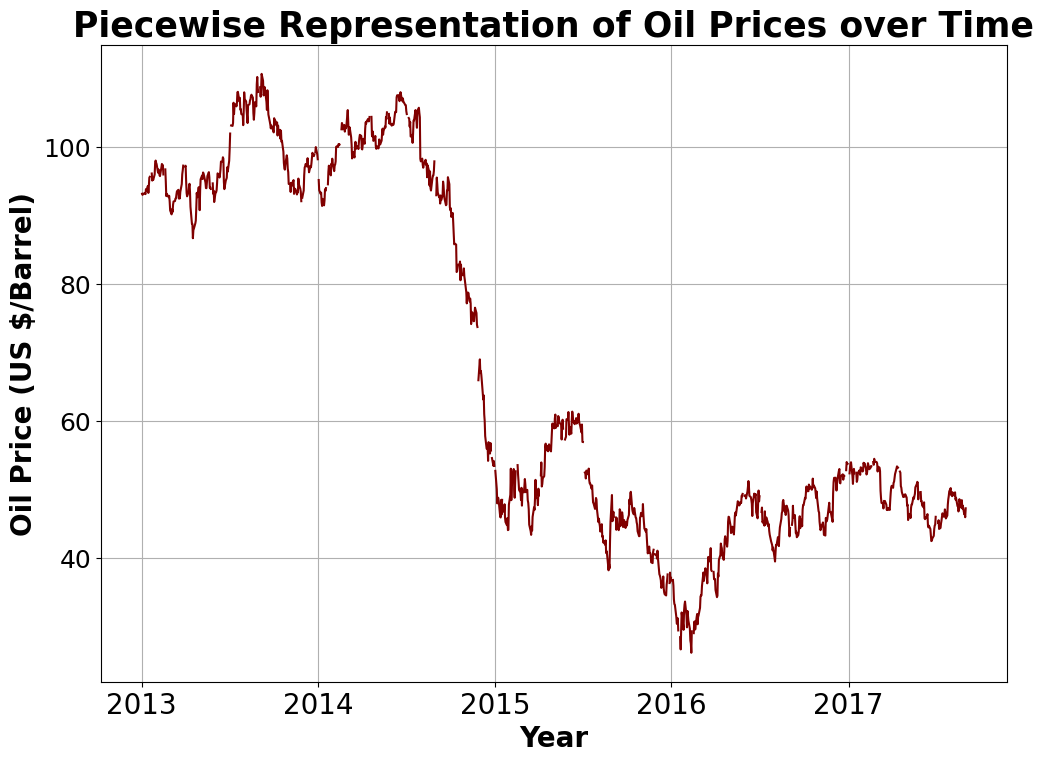

In [84]:
groups = plot_oil[ plot_oil["dcoilwtico"].notnull() ].groupby("group")

plot_oil = plot_oil[ plot_oil["group"] != 0 ]

n_groups = groups.ngroups

# fig, axes = plt.subplots(n_groups, 1, figsize = (30,20), sharex=True)
plt.figure( figsize=(11.69,8.27) )

# for (group_id, group_data), ax in zip(groups, axes):
for group_id, group_data in groups:
    plt.plot(group_data["date"], group_data["dcoilwtico"], color="maroon", label=f"Oil Price Group {group_id}") #marker="o", color="blue"

plt.title("Piecewise Representation of Oil Prices over Time", size=25, fontweight="bold")
plt.xlabel("Year", size=20, fontweight="bold")
plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

plt.xticks(size="20")
plt.yticks(size="18")
plt.grid(axis="both")


plt.savefig("../images/oil_piecewise_over_time.png", format="png", dpi=300)

# plt.grid

The chart above represents the trends of oil price per barrel over time. We omitted any data coinciding with `NaN` values - which is why we classify this as a piecewise line chart. There are some things worth considering here...

A previous study chose to backfill pricing data, where the next row's price would be duplicated into the previous row's price. I personally wouldn't criticize this approach. There's only so much one can do with the limitations provided. To be different and address some of the gaps, I personally will attempt linear interpolation as the trend jumps are minimal between specific points, but large enough that backfilling will continue to sustain sharp drops (if anything encourage it). 

There is a sharp dropoff between 2014 and 2015 in oil prices. This trend has slight relief starting 2015 with a small increase in price, but then continues a trend downward until early 2016. After, some price recovery comes. (I say this like it's a bad thing....low oil prices should help the consumer haha).

Will look into this dropoff. Some theories are: war, energy competitiveness, administration changes, political changes, new-found large scale supply, sanction relief/better trade, etc. 

[Read this source](https://blogs.worldbank.org/en/developmenttalk/what-triggered-oil-price-plunge-2014-2016-and-why-it-failed-deliver-economic-impetus-eight-charts)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_1223/3085276289.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  plot_oil = plot_oil.interpolate(method="linear")


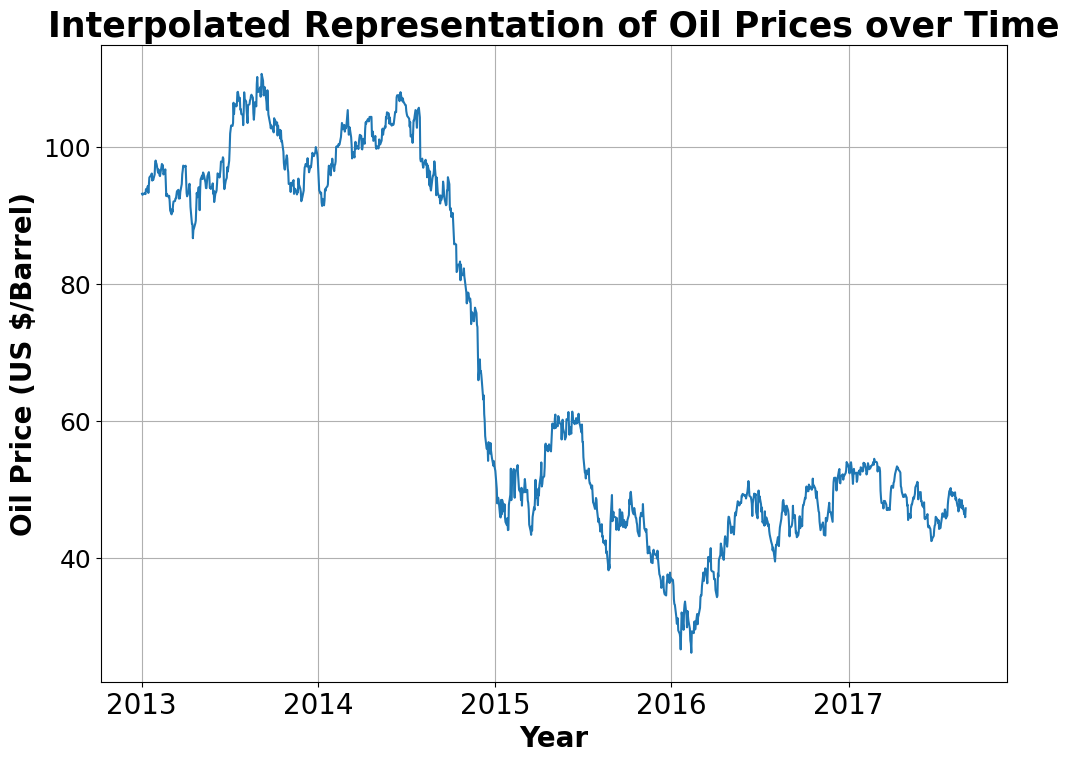

In [91]:
plot_oil = oil.copy()



plot_oil = plot_oil.interpolate(method="linear")

plt.figure( figsize=(11.69,8.27) )
plt.plot(plot_oil["date"], plot_oil["dcoilwtico"])


plt.title("Interpolated Representation of Oil Prices over Time", size=25, fontweight="bold")
plt.xlabel("Year", size=20, fontweight="bold")
plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

plt.xticks(size="20")
plt.yticks(size="18")
plt.grid(axis="both")

plt.savefig("../images/oil_interpolated_over_time.png", format="png", dpi=300)


In [ ]:
Through

In [42]:
print(n_groups)

42


In [31]:
display(
    oil[
        oil["dcoilwtico"].isnull()
    ]
)

,date,dcoilwtico,days_diff
0,2013-01-01,NaN,NaN
14,2013-01-21,NaN,3.0
34,2013-02-18,NaN,3.0
63,2013-03-29,NaN,1.0
104,2013-05-27,NaN,3.0
132,2013-07-04,NaN,1.0
174,2013-09-02,NaN,3.0
237,2013-11-28,NaN,1.0
256,2013-12-25,NaN,1.0
261,2014-01-01,NaN,1.0


### Null Handling

In [ ]:
def data_cleaning(df):
    # Datetime Conversions
    df["date"] = pd.to_datetime(df["date"])

    #Feature Reduction
    #drop the `locale` column (not sure if that makes sense.)...also is hierarchy applied here? maybe not. 

    # Null Handling
    pass

## Merges

### Pre-merge Analysis

In [ ]:
#Holiday merge might need something clever like "is_holiday" as a column. We may have to also see how many cities apply to one unique holiday which can gage the weight of a holiday's importance. 

### Merge and Review

In [ ]:
#value count the new dates' instances

#collect the omitted dates from each table from the final table

# Plotting and Feature Exploration

### Sales Aggregations per category

### Geographical Plotting of Store Locations

In [ ]:
### 

# Modeling

## Modeling

**Model pre-processing: transformation**

**Modeling**

## Plotting & Analysis

I might make a trackable hyperparameter tuning table. So take all the hyperparameters and showcase the progress of work. 

## Conclusion

# Appendix

## Individual Plot Date Diff Exploration

I will be making a matplotlib subplot comparison of plots to understand the date difference sparcisty within the columns. Not sure if the plot will have major impactful value, but will otherwise explore it nontheless. 

Two plots come to mind:

- histogram with bin counts of the date-diff precense in each 
- sorted by date barchart directly indicating where the largest days diff happen to be
- 

Plot the price of oil overtime to assess how to address how extrapolation or filling can occur (first remove the nulled rows before diving into it). 